In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score


import matplotlib.pyplot as plt

%matplotlib inline

Источник Датасета - https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset

In [2]:
df = pd.read_excel("C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/HomeWork/Raisin_Dataset/Raisin_Dataset.xlsx")
df.head(3)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


Были изучены изображения сортов изюма Kecimen и Besni, выращенных в Турции. Всего было использовано 900 зерен изюма, в том числе 450 штук из обоих сортов. Эти изображения были подвергнуты различным стадиям предварительной обработки, и было выделено 7 морфологических признаков. Данные этих признаков отражены в таблице. 
 - Необходимо обучить модель классификации сортов изюма по количественным признакам.

Все признаки числовые

In [4]:
df['Class'].value_counts()

Kecimen    450
Besni      450
Name: Class, dtype: int64

таргет сбалансирован. Приведём его к числовому виду.

In [5]:
def target_variable(var):
    return 1 if var == 'Kecimen' else 0

In [6]:
df['Class'] = df['Class'].apply(target_variable)

In [7]:
df.head(3)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,1
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,1
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,1


In [8]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Class'), df['Class'], random_state=42)

In [9]:
X_train.head(3)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
613,117714,480.629674,314.026534,0.757043,120922,0.724300,1361.884
528,114289,580.600830,261.763698,0.892600,120657,0.649487,1455.893
815,117354,520.326612,289.661986,0.830719,121057,0.712065,1374.171


Так как все признаки количественные напишем класс выбор числового признака.

In [10]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

Создадим список признаков

In [11]:
continuous_columns = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']

Перед обучением преобразуем наши данные с помощью StandardScaler.

In [12]:
continuos_transformers = []

for cont_columns in continuous_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_columns)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_columns, transfomer))

Перед размещением в pipeline объединим признаки с помощью FeatureUnion.

In [13]:
feats = FeatureUnion(continuos_transformers)
feature_processing = Pipeline([('feats', feats)])

запустим предобработку данных.

In [14]:
feature_processing.fit_transform(X_train)

array([[ 0.75106207,  0.41990635,  1.17688387, ...,  0.71769468,
         0.45627178,  0.71171931],
       [ 0.66451096,  1.27602603,  0.14642306, ...,  0.71125988,
        -0.91234575,  1.05471877],
       [ 0.74196472,  0.75985771,  0.69649065, ...,  0.72097279,
         0.23244067,  0.75654943],
       ...,
       [ 1.98779517,  1.51063312,  1.8794452 , ...,  1.88659529,
         0.99077238,  1.48624012],
       [-1.51058769, -1.59451113, -2.05236784, ..., -1.48242598,
        -1.40984086, -1.76522946],
       [-0.76278618, -1.04155205, -0.25574613, ..., -0.78702992,
         0.20100398, -0.93024072]])

In [15]:
# Создадим классификатор на LogisticRegression
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(C=0.1, random_state=42)),
])

In [16]:
# запустим кросс-валидацию на метрике roc_auc c 7-мью фолдами
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(cv_scores)
print(f'CV score is {cv_score:0.3f} with a standard deviation of {cv_score_std:0.4f}')

[0.92638298 0.90553191 0.93792517 0.94311767 0.88276162 0.93399913
 0.93747286]
CV score is 0.924 with a standard deviation of 0.0203


Имеем стабильные показатели модели классификации по выбранной метрике. Обучим пайплайн на всем тренировочном датасете

In [17]:
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

Определим оптимальную отсечку для задачи класиификации. Посчитаем precision / recall / f_score

In [18]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.43341239133026965, F-Score=0.878, Precision=0.889, Recall=0.867


Обе метрики и Precision и Recall достаточно высокие. Модель неплохо справилась с разделением на классы.
13% первого класса модель не находит и 11% допускает ошибок в первом классе.

Так выглядит работа модели при лучшей отсечке на первых n экземплярах.

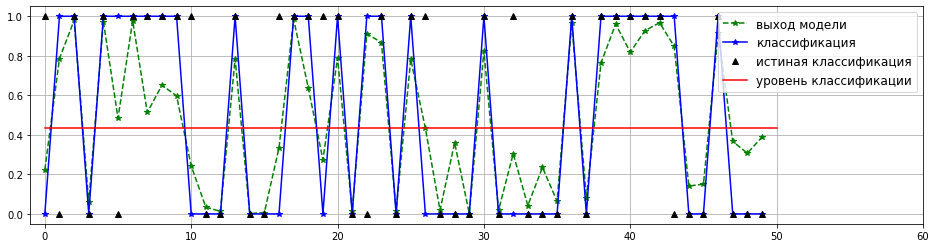

In [19]:
plt.figure(figsize=(16,4))
n = 50
plt.plot(y_score[:n] , '--*g', label = 'выход модели')
plt.plot(y_score[:n] > thresholds[ix], '-*b', label = 'классификация')
plt.plot(y_test.values[:n], '^k', label = 'истиная классификация')
plt.grid('on')
plt.xlim([-1, n + 10])
plt.plot([0,n], [thresholds[ix],thresholds[ix]],'r', label = 'уровень классификации')
plt.legend(loc='upper right', fontsize=12)
plt.show()

Нарисуем roc auc кривую.

In [20]:
import seaborn as sns

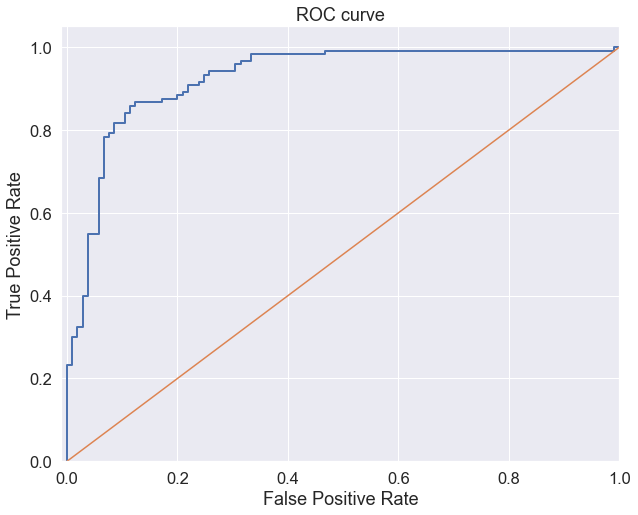

In [21]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [22]:
print(f"roc auc score: {roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])}")

roc auc score: 0.9252086078173034
roc auc score: 0.9262698412698412


На тестовой выборке получили метрику немного, но получше чем на тренеровочной. 

Построим матрицу ошибок

In [23]:
import itertools

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['axes.grid'] = False
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 92  13]
 [ 17 103]]


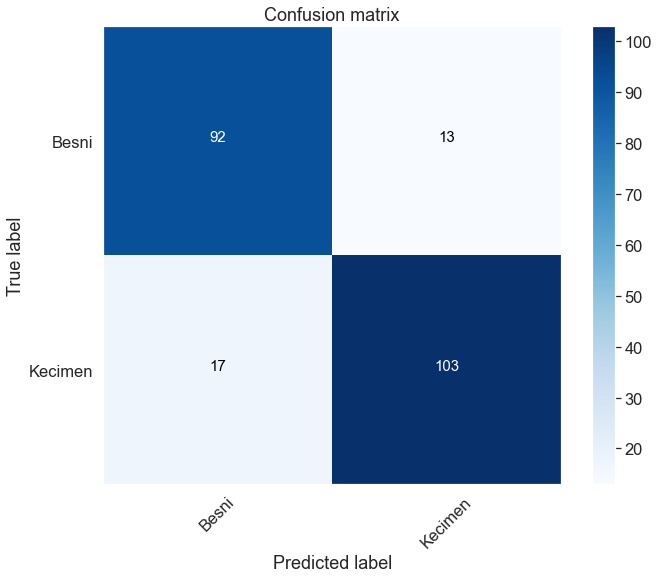

In [25]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Besni', 'Kecimen'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем метрики TPR, FPR, TNR

In [26]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [27]:
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
TNR = TN / (FP + TN)
Accuracy =  (TP + TN)/(TP + TN + FP + FN)
print(f'TPR={TPR:0.3f}, FPR={FPR:0.3f}, TNR={TNR:0.3f}, Accuracy={Accuracy:0.3f}')

TPR=0.858, FPR=0.124, TNR=0.876, Accuracy=0.867


Подытожим: модель в целом не плохо справляется в задаче отнесения тестовых образцов к нужным классам, как 0-го (TNR) так и первого класса (TPR). 

In [28]:
from sklearn.metrics import classification_report

In [29]:
report = classification_report(y_test, classifier.predict(X_test), target_names=['Besni', 'Kecimen'])

In [30]:
print(report)

              precision    recall  f1-score   support

       Besni       0.82      0.90      0.86       105
     Kecimen       0.90      0.83      0.87       120

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.87      0.86      0.86       225



In [31]:
features = pd.DataFrame(classifier[1].coef_.reshape(7, 1), continuous_columns, columns=['coefficient'])

In [32]:
features.sort_values('coefficient', ascending=False)

,coefficient
Extent,0.245900
MinorAxisLength,-0.192051
Area,-0.424646
ConvexArea,-0.476809
Eccentricity,-0.538402
MajorAxisLength,-0.679367
Perimeter,-0.870607


Интерпретация:
1. наибольшую важность отнесения к целевому классу имеет признак Extent. Чем больше/меньше показатель признака тем выше вероятность отнесения к целевому классу.
2. остальные признаки идут с отрицательным весом. Из них признак Perimeter по модулю наибольший, что можно интерпретировать как сильным признаком отнесения образца к противоположному (чем признак Extent) классу. Вторым по важности отнесения к противоположному классу (чем признак Extent) является признак MajorAxisLength, который также отрицательный по значению и чем меньше значение тем вероятнее отнесения к противоположному классу.

In [33]:
df.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636,0.500000
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315,0.500278
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000,0.000000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750,0.000000
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000,0.500000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750,1.000000
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000,1.000000


In [38]:
df.loc[df['Extent'] < 0.67]['Class'].value_counts()

0    135
1     84
Name: Class, dtype: int64

In [199]:
df.loc[df['Perimeter'] < 966]['Class'].value_counts()

1    204
0     20
Name: Class, dtype: int64

In [36]:
df.loc[df['MajorAxisLength'] < 345]['Class'].value_counts()

1    207
0     17
Name: Class, dtype: int64

In [39]:
from sklearn.inspection import permutation_importance

r = permutation_importance(classifier, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [40]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

Perimeter 0.062 +/- 0.016
MajorAxisLength 0.040 +/- 0.014
Eccentricity 0.021 +/- 0.014
ConvexArea 0.018 +/- 0.010
Area     0.013 +/- 0.009
Extent   0.012 +/- 0.008
MinorAxisLength 0.002 +/- 0.006


Результаты метода перемешивания признаков изменило растановку по важности и приблизило модель к важности признаков от "деревянных" моделей, рассмотренных ниже.

### Важность признаков в нашей задаче классификации с помощью модуля Shap
 - кроме Shap буду использовать модули eli5, lime

In [41]:
import shap

In [42]:
dtCl_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42,)
dtCl_model.fit(X_train, y_train)

y_preds = dtCl_model.predict(X_test)

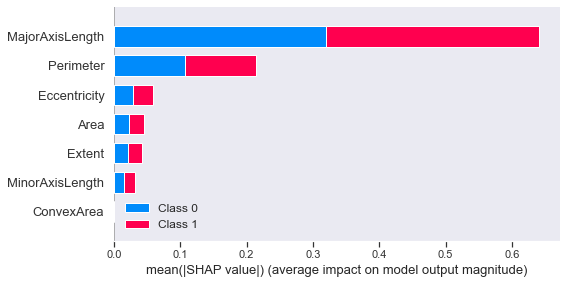

In [173]:
# строим модель объяснения в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(dtCl_model)
shap_values = explainer.shap_values(X_test)

# покажем объяснение
# shap.initjs() # для работы в колабе
shap.summary_plot(shap_values, X_test)

- Самый значимый по важности в предсказании модели целевого признака - признак MajorAxisLength
- Второй по значимости признак Perimeter
- остальные признаки с заметным отстованием

Explained expected value: [[ 0.01883906 -0.33985083  0.01028631 ...  0.         -0.01174535
  -0.14803099]
 [-0.01249222  0.27632643 -0.03002746 ...  0.          0.00085234
   0.06613162]
 [-0.01249222  0.30267381 -0.00857284 ...  0.          0.02145613
   0.11080185]
 ...
 [-0.01249222  0.28095675 -0.03002746 ...  0.          0.02145613
   0.03700486]
 [-0.01249222  0.27001904 -0.01057961 ...  0.         -0.07047578
   0.04836046]
 [-0.01249222  0.31438769 -0.00857284 ...  0.          0.00085234
   0.16426222]]


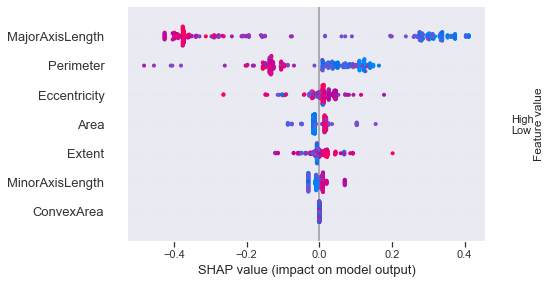

In [174]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f'Explained expected value: {shap_values}')

shap.summary_plot(shap_values, X_test)

 - К самому важному признаку модель DecisionTreeClassifier отнесла признак MajorAxisLength (Задает длину главной оси, которая является самой длинной линией, которую можно провести на рельефе).
     По графическому представлению признака видим практически "чистое" разделение на два класса с небольшими вкраплениями противоположного класса. Для признака MajorAxisLength чем меньше значение признака (синия область) тем больше вероятность (ближе к краю правой стороны) относения экземпляра к целевому классу 1 (правая часть).
 - Второй по значимости признак Perimeter (Он измеряет окружение, вычисляя расстояние между границами изюминки и пикселями вокруг нее).
     Предыдущий вывод про "чистое" деление на два класса и другие выводы относится и к признаку Perimeter.
 - Третий по значимости Eccentricity (Это дает меру эксцентриситета эллипса, который имеет те же моменты, что и изюм).
     В графическом представлении этого признака нет четкого деления на классы - и большие и малые значения признака группируются преимущественно в одной области с небольшим смещением вправо в сторону целевого класса.
 - Остальные признаки имеют значение коэффициентов Shap'ли близко по модулю к 0 и имеют слабое влияние на прогнозирование модели.

In [81]:
from lightgbm import LGBMClassifier

In [224]:
lgb_model = LGBMClassifier(max_depth=5, num_leaves=10, random_state=42)
lgb_model.fit(X_train, y_train)

y_preds = lgb_model.predict(X_test)

In [225]:
# строим модель объяснения в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


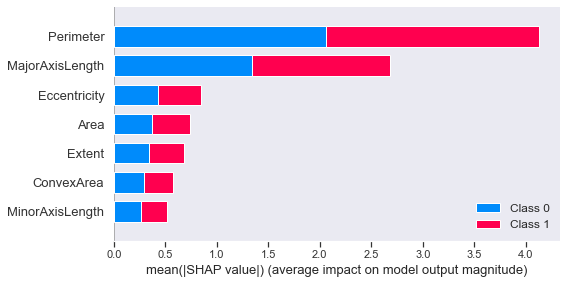

In [226]:
# покажем объяснение
shap.initjs() # для работы в колабе
shap.summary_plot(shap_values, X_test)

Первые три признака единтичны с предыдущей моделью DecisionTreeClassifier.

In [205]:
# load JS visualization code to notebook
shap.initjs()

Explained expected value: [[ 0.50063246 -0.64699003  0.74815858 ...  0.36497926  0.21967993
  -2.10757801]
 [-1.1287472   0.93470954 -0.23878258 ...  0.07136468 -0.26174903
   0.76141112]
 [-0.49319852  1.71607531 -0.02601116 ...  0.28559339  0.20669939
   2.91746099]
 ...
 [-0.11138072  1.08716384  0.12138487 ... -0.09708393 -0.30457259
   2.10763491]
 [-0.65454948  1.08035302 -0.18106177 ...  0.18133905 -0.40199911
   1.55580551]
 [-0.39929868  1.2670642  -0.13638101 ...  0.24413818 -0.15459152
   2.05337465]]


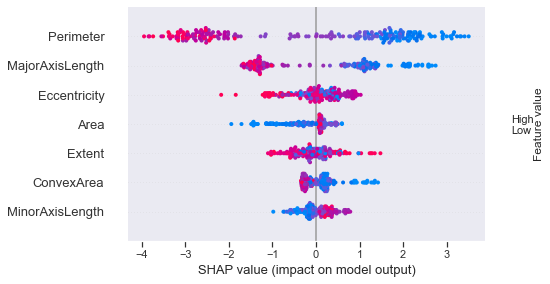

In [227]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f'Explained expected value: {shap_values}')

shap.summary_plot(shap_values, X_test)

Выводы о влияние на прогноз первых двух признаков совпадают с выводами в предыдущей модели. Маленькие значения признаков MajorAxisLength и Perimeter "тянут" экземпляр в первый класс.

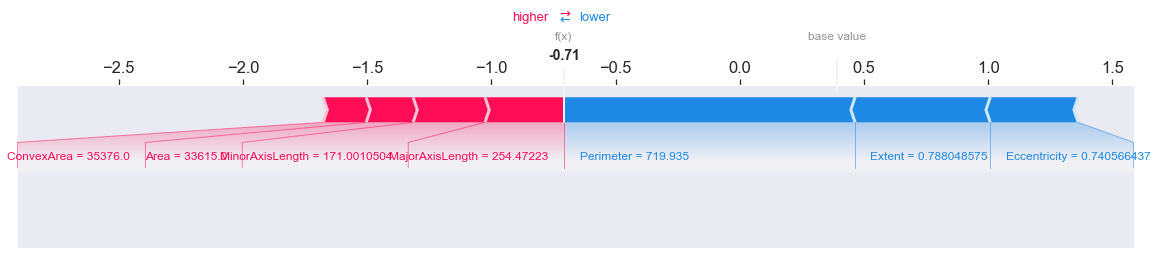

In [228]:
# visualize the first prediction's explanation
# shap.initjs()
idx = 5
shap.force_plot(explainer.expected_value[0], shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

Значения вероятности отнесения даннго экземпляра к первому классу (-0.71)  ниже среднего по всем экземплярам (base value=0.39)
Значение признака Perimeter "склоняет" модель признать экземпляр не к первому классу, в то же время второй по важности признак MajorAxisLength "склоняет" модель присвоить ему класс 1. Но по абсолютным значениям модель склоняется признать за экземпляром класс 0.

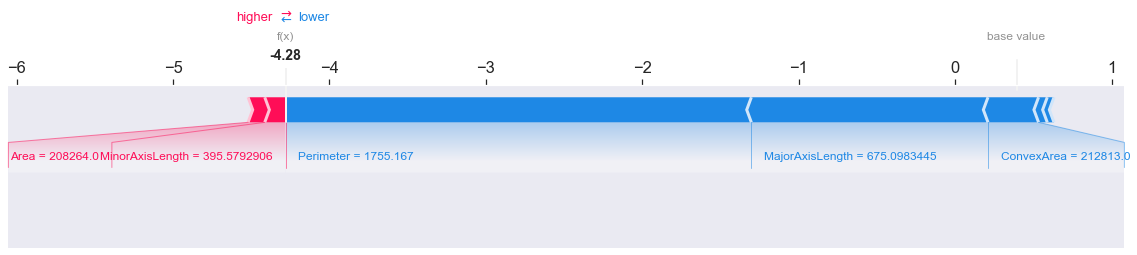

In [229]:
# visualize the first prediction's explanation
# shap.initjs()
idx = 10
shap.force_plot(explainer.expected_value[0], shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

- В этом случае оба важных признака Perimeter и MajorAxisLength склоняют модель к признанию объекта к нулевому классу (самое весомое влияние у признака Perimeter), в противоположном направлении в данном случае работает признак Area (с небольшим влиянием).

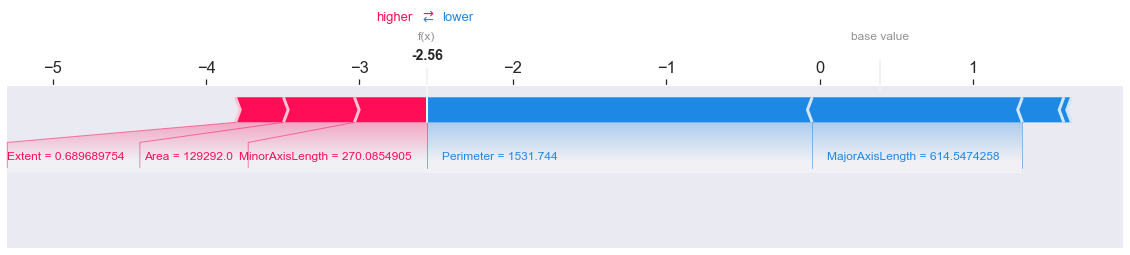

In [230]:
# visualize the first prediction's explanation
# shap.initjs()
idx = 45
shap.force_plot(explainer.expected_value[0], shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

- В этом случае также можно наблюдать, что оба важных признака Perimeter и MajorAxisLength склоняют модель к признанию объекта к нулевому классу (самое весомое влияние у признака Perimeter), в противоположном направлении в данном случае работает признак Area и MinorAxisLength (оба с небольшим влиянием).

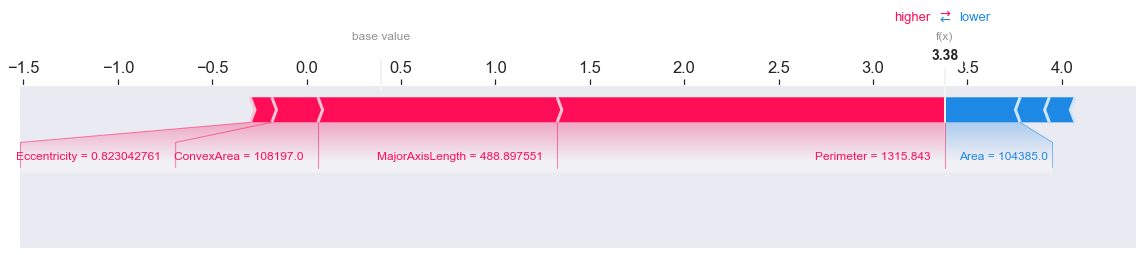

In [231]:
# visualize the first prediction's explanation
# shap.initjs()
idx = 224
shap.force_plot(explainer.expected_value[0], shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

- В этом случае наблюдаем суммарное значение коэффициентов shap'ли больше базового значения по всем объектам, что подразумевает отнесения моделью этого экземпляра к первому классу. Оба важных признака Perimeter и MajorAxisLength склоняют модель к признанию объекта к первому классу (самое весомое влияние опять у признака Perimeter), в противоположном направлении в данном случае работает признак Area и Extent (оба с небольшим влиянием).

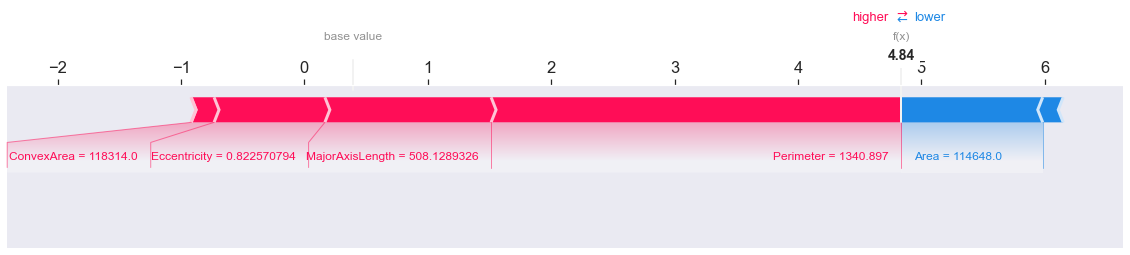

In [232]:
# visualize the first prediction's explanation
# shap.initjs()
idx = 101
shap.force_plot(explainer.expected_value[0], shap_values[idx,:], X_train.iloc[idx,:], matplotlib=True)

- Описание влияния признаков как и в предыдущем примере.

In [162]:
import xgboost

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


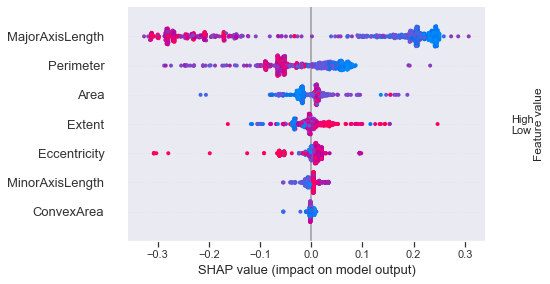

In [233]:
model = xgboost.train({"learning_rate": 0.01, 'random_state': 1}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

shap.summary_plot(shap_values_all, X_train)

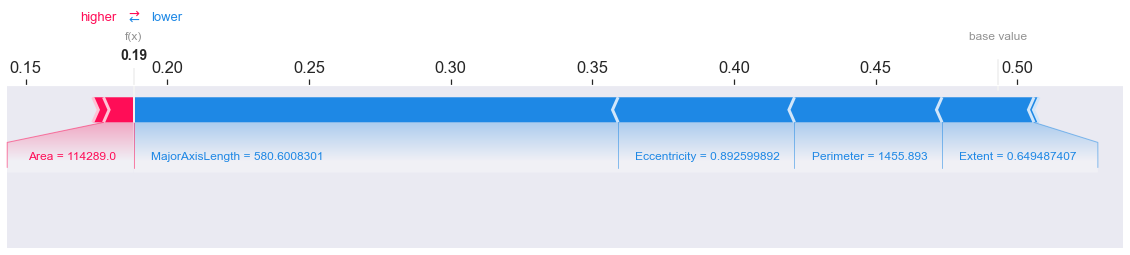

In [234]:
# visualize the first prediction's explanation
# shap.initjs()
idx = 1
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:], matplotlib=True)

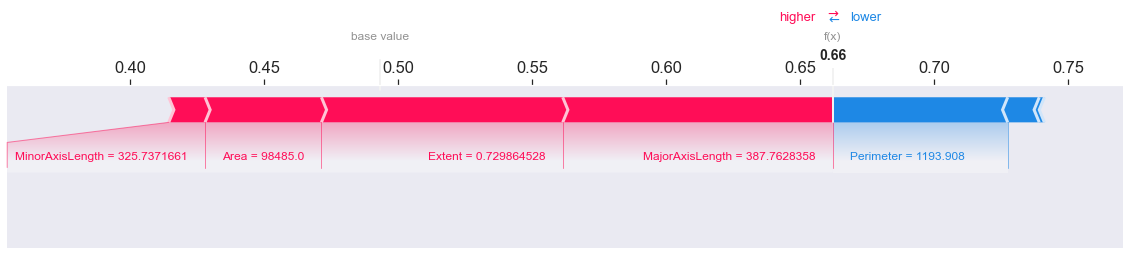

In [235]:
# shap.initjs()
idx = 100
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:], matplotlib=True)

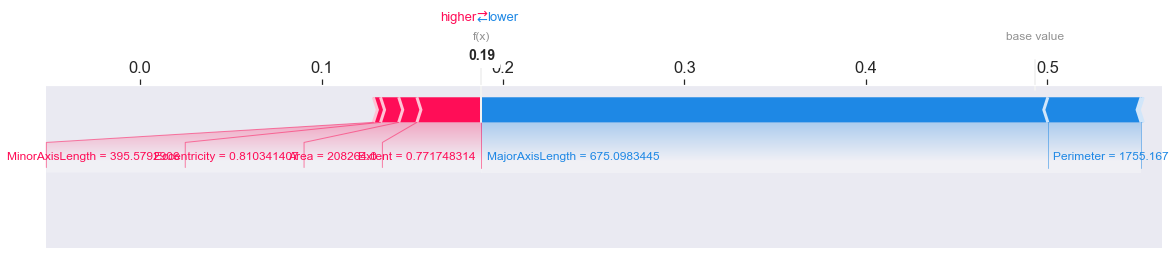

In [236]:
# shap.initjs()
idx = 10
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:], matplotlib=True)

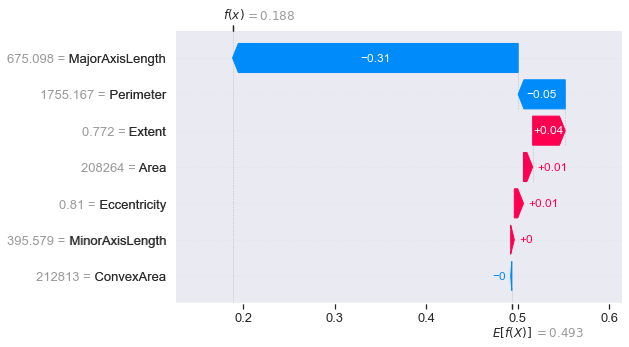

In [238]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

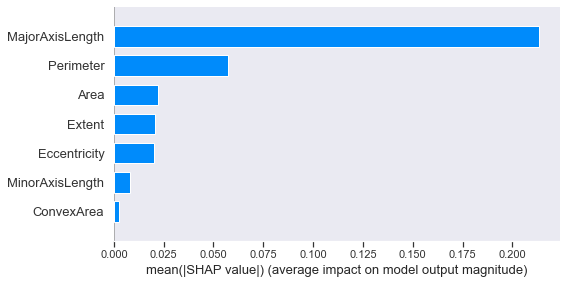

In [170]:
shap.summary_plot(shap_values_all, X_train, plot_type="bar")

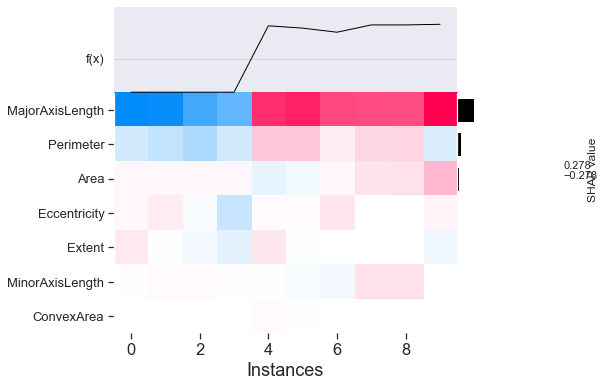

In [171]:
n = 10
shap_values = explainer(X_train.iloc[:n])
shap.plots.heatmap(shap_values)

In [242]:
# shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_all[:n], X_train.iloc[:n])